In [1]:
import struct
from PIL import Image
import numpy as np

def read_record_ETL8G(f):
    s = f.read(8199)
    r = struct.unpack('>2H8sI4B4H2B30x8128s11x', s)
    iF = Image.frombytes('F', (128, 127), r[14], 'bit', 4)
    iL = iF.convert('L')
    return r + (iL,)

def read_kanji():
    kanji = np.zeros([883, 160, 127, 128], dtype=np.uint8)
    for i in range(1, 33):
        filename = 'D:/ETL8G/ETL8G_{:02d}'.format(i)
        with open(filename, 'rb') as f:
            for dataset in range(5):
                char = 0
                for j in range(956):
                    r = read_record_ETL8G(f)
                    if not (b'.HIRA' in r[2] or b'.WO.' in r[2]): 
                        kanji[char, (i - 1) * 5 + dataset] = np.array(r[-1])
                        char += 1
    np.savez_compressed("kanji.npz", kanji)

read_kanji()

KeyboardInterrupt: 

In [144]:
import skimage.transform as tr
import numpy as np
from sklearn.model_selection import train_test_split

kanji = 879
rows = 64
cols = 64

kan = np.load("kanji.npz")['arr_0'].reshape([-1, 127, 128]).astype(np.float32)

kan = kan/np.max(kan)

train_images_numbers = np.arange(600)
train_images_rest = np.array([614,687,695,741,754,797,872,875,880])


train_images_numbers = np.concatenate((train_images_numbers, train_images_rest))

train_images_before = np.zeros([(len(train_images_numbers)-4) * 160, rows, cols], dtype=np.float32)


#train_labels_numbers = [26,64,158,209,321,328,331,394,480,610,683,750,793,876]
h = 0
for i in range(len(train_images_numbers)):
	if( train_images_numbers[i] == 88 or train_images_numbers[i]  == 219 or train_images_numbers[i]  == 349 or train_images_numbers[i]  == 457 ): 
		h +=1
		continue
	else :
		for j in range(160):
			train_images_before[(i-h)*160+j] = tr.resize(kan[(train_images_numbers[i])*160+j],(rows,cols))

train_labels_numbers = np.arange(len(train_images_numbers)-4)
train_labels = np.repeat(train_labels_numbers, 160)

# 4 characters were actually hiragana, so delete these 4 extras
#for i in range( (kanji+4) * 160):
#	if int(i/160) != 88 and int(i/160) != 219 and int(i/160) != 349 and int(i/160) != 457:
#		if int(i/160) < 88:
#			train_images[i] = skimage.transform.resize(kan[i], (rows, cols))
#		if int(i/160) > 88 and int(i/160) < 219:
#			train_images[i-160] = skimage.transform.resize(kan[i], (rows, cols))
#		if int(i/160) > 219 and int(i/160) < 349:
#			train_images[i-320] = skimage.transform.resize(kan[i], (rows, cols))
#		if int(i/160) > 349 and int(i/160) < 457:
#			train_images[i-480] = skimage.transform.resize(kan[i], (rows, cols))
#		if int(i/160) > 457:
#			train_images[i-640] = skimage.transform.resize(kan[i], (rows, cols))

#writing to add cahnges aaaaaa

train_images, test_images, train_labels, test_labels = train_test_split(train_images_before, train_labels, test_size=0.2)

np.savez_compressed("kanji_train_images.npz", train_images)
np.savez_compressed("kanji_train_labels.npz", train_labels)
np.savez_compressed("kanji_test_images.npz", test_images)
np.savez_compressed("kanji_test_labels.npz", test_labels)





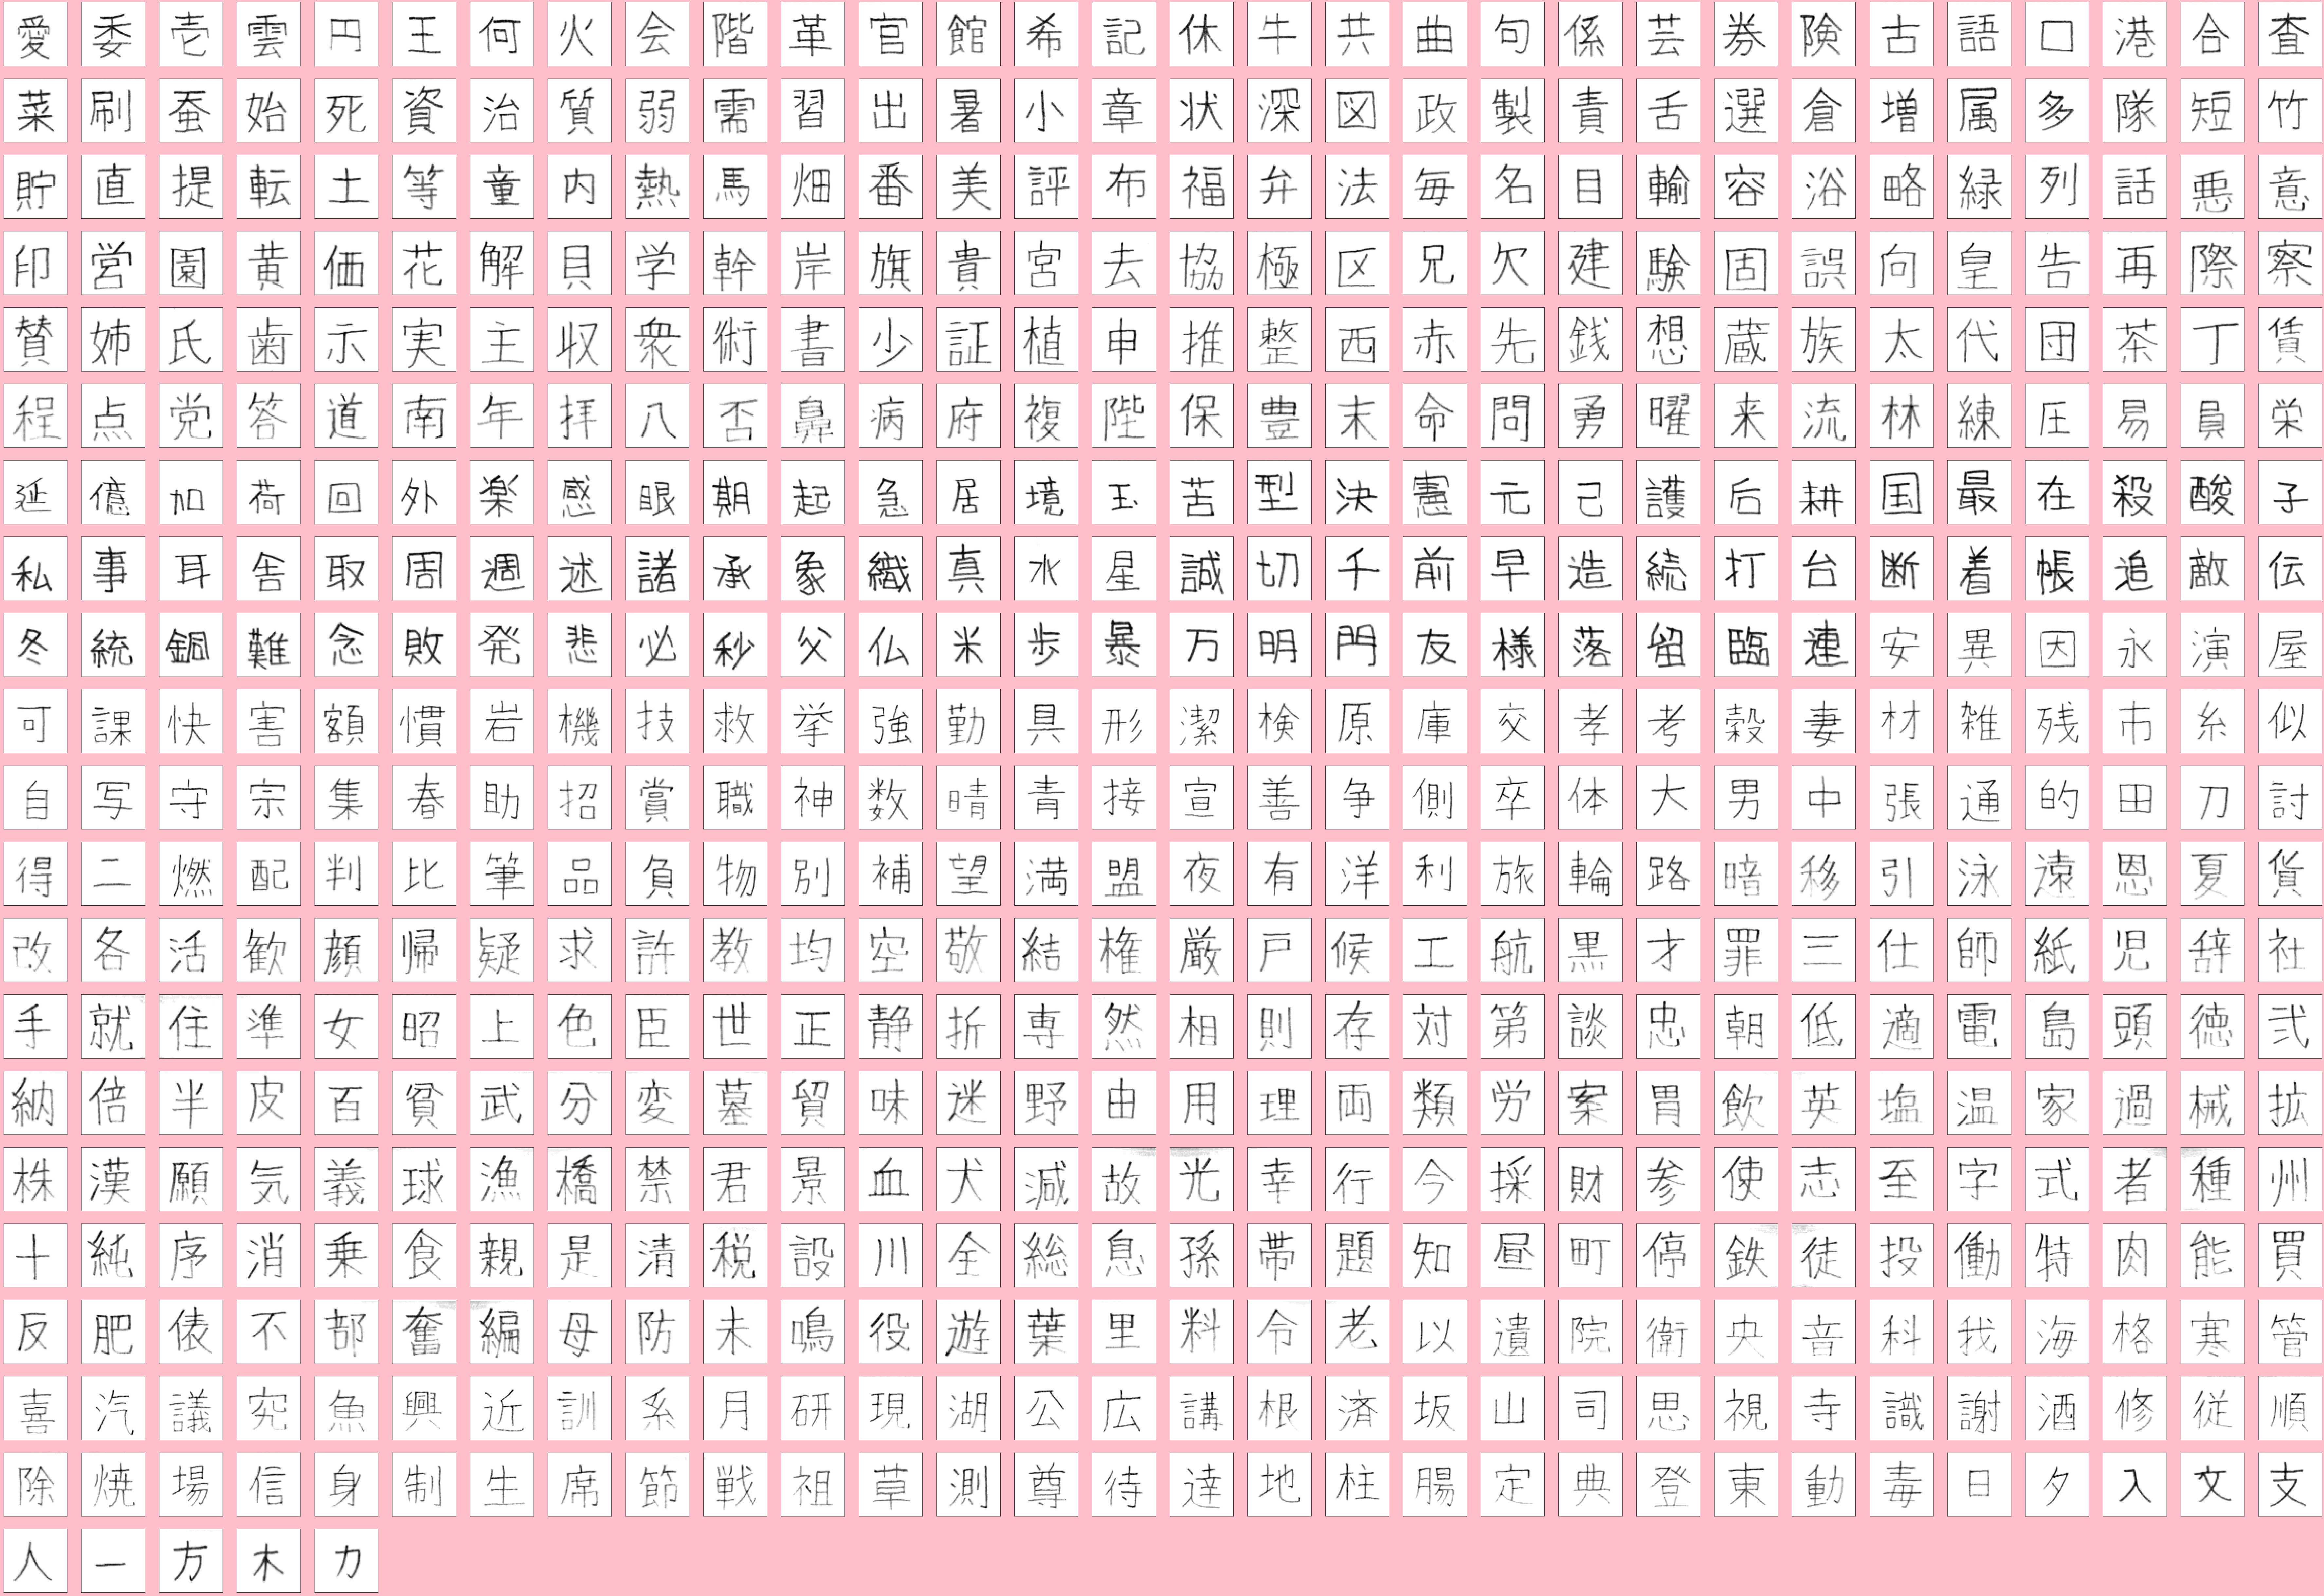

In [145]:
import matplotlib.pyplot as plt
plt.figure(figsize=(127,128)).patch.set_facecolor('pink')
for i in range(len(train_images_numbers)-4):
    plt.subplot(30,30,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images_before[i*160], cmap=plt.cm.binary)
plt.show()

In [146]:
from tensorflow import keras
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

train_images = np.load("kanji_train_images.npz")['arr_0']
train_labels = np.load("kanji_train_labels.npz")['arr_0']
test_images = np.load("kanji_test_images.npz")['arr_0']
test_labels = np.load("kanji_test_labels.npz")['arr_0']

if K.image_data_format() == "channels_first":
  train_images = train_images.reshape(train_images.shape[0], 1,rows,cols)
  test_images = test_images.reshape(test_images.shape[0], 1,rows,cols)
  shape = (1,rows,cols)
else:
  train_images = train_images.reshape(train_images.shape[0], rows,cols, 1)
  test_images = test_images.reshape(test_images.shape[0], rows,cols, 1)
  shape = (rows,cols,1)
  
datagen = ImageDataGenerator(rotation_range=18,zoom_range=0.2)
datagen.fit(train_images)
model = keras.Sequential([
  keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=shape),
  keras.layers.MaxPooling2D(2,2),
  keras.layers.Conv2D(64, (3,3), activation='relu'),
  keras.layers.MaxPooling2D(2,2),
  keras.layers.Flatten(),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(200, activation='relu'),
  keras.layers.Dense(609, activation="softmax")
])


model.summary()

model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
              
model.fit_generator(datagen.flow(train_images,train_labels,shuffle=True),epochs=50,validation_data=(test_images,test_labels),callbacks = [keras.callbacks.EarlyStopping(patience=8,verbose=1,restore_best_weights=True),keras.callbacks.ReduceLROnPlateau(factor=0.5,patience=3,verbose=1)])

test_loss, test_acc = model.evaluate(test_images, test_labels)
print("Test Accuracy: ", test_acc)

model.save("kanji.h5")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dropout (Dropout)           (None, 12544)             0

C:\Users\Pc\AppData\Local\Temp\ipykernel_16948\3448692011.py:38: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(datagen.flow(train_images,train_labels,shuffle=True),epochs=50,validation_data=(test_images,test_labels),callbacks = [keras.callbacks.EarlyStopping(patience=8,verbose=1,restore_best_weights=True),keras.callbacks.ReduceLROnPlateau(factor=0.5,patience=3,verbose=1)])


Epoch 1/50
2420/2420 [==============================] - 344s 140ms/step - loss: 3.0190 - accuracy: 0.3619 - val_loss: 0.7388 - val_accuracy: 0.7929 - lr: 0.0010
Epoch 2/50
2420/2420 [==============================] - 341s 140ms/step - loss: 1.0719 - accuracy: 0.7083 - val_loss: 0.4282 - val_accuracy: 0.8796 - lr: 0.0010
Epoch 3/50
2420/2420 [==============================] - 339s 140ms/step - loss: 0.7553 - accuracy: 0.7917 - val_loss: 0.3130 - val_accuracy: 0.9091 - lr: 0.0010
Epoch 4/50
2420/2420 [==============================] - 336s 138ms/step - loss: 0.6020 - accuracy: 0.8292 - val_loss: 0.2600 - val_accuracy: 0.9233 - lr: 0.0010
Epoch 5/50
2420/2420 [==============================] - 335s 138ms/step - loss: 0.5113 - accuracy: 0.8524 - val_loss: 0.2209 - val_accuracy: 0.9340 - lr: 0.0010
Epoch 6/50
2420/2420 [==============================] - 335s 138ms/step - loss: 0.4463 - accuracy: 0.8692 - val_loss: 0.1792 - val_accuracy: 0.9466 - lr: 0.0010
Epoch 7/50
2420/2420 [============

In [156]:
import tensorflowjs as tfjs
from tensorflow import keras

model = keras.models.load_model("kanji.h5")   # for example
tfjs.converters.convert(model, "DRAW-CANVAS/tfjs_file/",input_names=["image"],image_input_names = 'image', image_scale=1/255.0)

TypeError: convert() got an unexpected keyword argument 'input_names'

1/1 [==============================] - 3s 3s/step


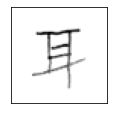

In [148]:
from tensorflow import keras
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import matplotlib.pyplot as plt
import PIL as pil


train_images_before = np.load("kanji_train_images.npz")['arr_0']
train_labels = np.load("kanji_train_labels.npz")['arr_0']

if K.image_data_format() == "channels_first":
  train_images = train_images.reshape(train_images_before.shape[0], 1,rows,cols)
  shape = (1,rows,cols)
else:
  train_images = train_images.reshape(train_images_before.shape[0], rows, cols, 1)
  shape = (rows,cols,1)

model = keras.models.load_model("kanji.h5") 
output = model.predict(np.expand_dims(train_images[27], axis=0))
predicted_class = np.argmax(output)
match = train_labels[27]

my_dpi =2
px = 1/plt.rcParams['figure.dpi']
plt.figure(figsize=(127*px,128*px))
plt.subplot(1,1,1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(train_images_before[27], cmap=plt.cm.binary)
plt.show()
image2 = Image.fromarray((train_images_before[27]*255).astype(np.uint8))
image2 = image2.convert("L")
image2 = pil.ImageOps.invert(image2)
image2.save('filename2.png', format='PNG')

1/1 [==============================] - 3s 3s/step


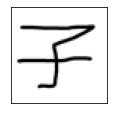

In [157]:
# load image and convert to and from NumPy array
from PIL import Image
import PIL as pil
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
# load the image
image = Image.open('ko.jpg').convert('RGB')
# convert image to numpy array

#image = image
image = pil.ImageOps.invert(image)
image = image.resize((64,64)).convert('L')
data = (np.asarray(image).astype(np.float32)/255)

model = keras.models.load_model("kanji.h5") 

# check prediction
getready = data.reshape(64,64,1)
output = model.predict(np.expand_dims(getready, axis=0))
predicted_class = np.argmax(output)


my_dpi =2
px = 1/plt.rcParams['figure.dpi']
plt.figure(figsize=(127*px,128*px))
plt.subplot(1,1,1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(data, cmap=plt.cm.binary)
plt.show()

In [4]:
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import skimage.transform as tr
from keras import backend as K
import matplotlib
from pathlib import Path

import matplotlib.font_manager as fm

label = ["愛",
"委",
"壱",
"雲",
"円",
"王",
"何",
"火",
"会",
"階",
"革",
"官",
"館",
"希",
"記",
"休",
"牛",
"共",
"曲",
"句",
"係",
"芸",
"券",
"険",
"古",
"語",
"口",
"港",
"合",
"査",
"菜",
"刷",
"蚕",
"始",
"死",
"資",
"治",
"質",
"弱",
"需",
"習",
"出",
"暑",
"小",
"章",
"状",
"深",
"図",
"政",
"製",
"責",
"舌",
"選",
"倉",
"増",
"属",
"多",
"隊",
"短",
"竹",
"貯",
"直",
"提",
"転",
"土",
"等",
"童",
"内",
"熱",
"馬",
"畑",
"番",
"美",
"評",
"布",
"福",
"弁",
"法",
"毎",
"名",
"目",
"輸",
"容",
"浴",
"略",
"縁",
"列",
"話",
"悪",
"意",
"印",
"営",
"園",
"黄",
"価",
"花",
"解",
"貝",
"学",
"幹",
"岸",
"旗",
"貴",
"宮",
"去",
"協",
"極",
"区",
"兄",
"欠",
"建",
"験",
"固",
"誤",
"向",
"皇",
"告",
"再",
"際",
"察",
"賛",
"姉",
"氏",
"歯",
"示",
"実",
"主",
"収",
"衆",
"術",
"書",
"少",
"証",
"植",
"申",
"推",
"整",
"西",
"赤",
"先",
"銭",
"想",
"蔵",
"族",
"太",
"代",
"団",
"茶",
"丁",
"賃",
"程",
"点",
"党",
"答",
"道",
"南",
"年",
"拝",
"八",
"否",
"鼻",
"病",
"府",
"複",
"陛",
"保",
"豊",
"末",
"命",
"問",
"勇",
"曜",
"来",
"流",
"林",
"練",
"圧",
"易",
"員",
"栄",
"延",
"億",
"加",
"荷",
"回",
"外",
"楽",
"感",
"眼",
"期",
"起",
"急",
"居",
"境",
"玉",
"苦",
"型",
"決",
"憲",
"元",
"己",
"護",
"后",
"耕",
"国",
"最",
"在",
"殺",
"酸",
"子",
"私",
"事",
"耳",
"舎",
"取",
"周",
"週",
"述",
"諸",
"承",
"象",
"織",
"真",
"水",
"星",
"誠",
"切",
"千",
"前",
"早",
"造",
"続",
"打",
"台",
"断",
"着",
"帳",
"追",
"敵",
"伝",
"冬",
"統",
"銅",
"難",
"念",
"敗",
"発",
"悲",
"必",
"秒",
"父",
"仏",
"米",
"歩",
"暴",
"万",
"明",
"門",
"友",
"様",
"落",
"留",
"臨",
"連",
"安",
"異",
"因",
"永",
"演",
"屋",
"可",
"課",
"快",
"害",
"額",
"慣",
"岩",
"機",
"技",
"救",
"挙",
"強",
"勤",
"具",
"形",
"潔",
"検",
"原",
"庫",
"交",
"孝",
"考",
"穀",
"妻",
"材",
"雑",
"残",
"市",
"糸",
"似",
"自",
"写",
"守",
"宗",
"集",
"春",
"助",
"招",
"賞",
"職",
"神",
"数",
"晴",
"青",
"接",
"宣",
"善",
"争",
"側",
"卒",
"体",
"大",
"男",
"中",
"張",
"通",
"的",
"田",
"刀",
"討",
"得",
"二",
"燃",
"配",
"判",
"比",
"筆",
"品",
"負",
"物",
"別",
"補",
"望",
"満",
"盟",
"夜",
"有",
"洋",
"利",
"旅",
"輪",
"路",
"暗",
"移",
"引",
"泳",
"遠",
"恩",
"夏",
"貨",
"改",
"各",
"活",
"歓",
"顔",
"帰",
"疑",
"求",
"許",
"教",
"均",
"空",
"敬",
"結",
"権",
"厳",
"戸",
"候",
"工(漢字)",
"航",
"黒",
"才",
"罪",
"三",
"仕",
"師",
"紙",
"児",
"辞",
"社",
"手",
"就",
"住",
"準",
"女",
"昭",
"上",
"色",
"臣",
"世",
"正",
"静",
"折",
"専",
"然",
"相",
"則",
"存",
"対",
"第",
"談",
"忠",
"朝",
"低",
"適",
"電",
"島",
"頭",
"徳",
"弐",
"納",
"倍",
"半",
"皮",
"百",
"貧",
"武",
"分",
"変",
"墓",
"貿",
"味",
"迷",
"野",
"由",
"用",
"理",
"両",
"類",
"労",
"案",
"胃",
"飲",
"英",
"塩",
"温",
"家",
"過",
"械",
"拡",
"株",
"漢",
"願",
"気",
"義",
"球",
"漁",
"橋",
"禁",
"君",
"景",
"血",
"犬",
"減",
"故",
"光",
"幸",
"行",
"今",
"採",
"財",
"参",
"使",
"志",
"至",
"字",
"式",
"者",
"種",
"州",
"十",
"純",
"序",
"消",
"乗",
"食",
"親",
"是",
"清",
"税",
"設",
"川",
"全",
"総",
"息",
"孫",
"帯",
"題",
"知",
"昼",
"町",
"停",
"鉄",
"徒",
"投",
"働",
"特",
"肉",
"能",
"買",
"反",
"肥",
"俵",
"不",
"部",
"奮",
"編",
"母",
"防",
"未",
"鳴",
"役",
"遊",
"葉",
"里",
"料",
"令",
"老",
"以",
"遺",
"院",
"衛",
"央",
"音",
"科",
"我",
"海",
"格",
"寒",
"管",
"喜",
"汽",
"議",
"究",
"魚",
"興",
"近",
"訓",
"系",
"月",
"研",
"現",
"湖",
"公",
"広",
"講",
"根",
"済",
"坂",
"山",
"司",
"思",
"視",
"寺",
"識",
"謝",
"酒",
"修",
"従",
"順",
"除",
"焼",
"場",
"信",
"身",
"制",
"生",
"席",
"節",
"戦",
"祖",
"草",
"測",
"尊",
"待",
"達",
"地",
"柱",
"腸",
"定",
"典",
"登",
"東",
"動",
"毒",
"日",
"夕",
"入",
"文",
"支",
"人",
"一",
"方",
"木",
"力"]

kan = np.load("kanji.npz")['arr_0'].reshape([-1, 127, 128]).astype(np.float32)

kan = kan/np.max(kan)

heatmap_images_numbers = np.arange(600)
heatmap_images_rest = np.array([614,687,695,741,754,797,872,875,880])


heatmap_images_numbers = np.concatenate((heatmap_images_numbers, heatmap_images_rest))

heatmap_images_before = np.zeros([(len(heatmap_images_numbers)-4), 64, 64], dtype=np.float32)


#train_labels_numbers = [26,64,158,209,321,328,331,394,480,610,683,750,793,876]
h = 0
for i in range(len(heatmap_images_numbers)):
	if( heatmap_images_numbers[i] == 88 or heatmap_images_numbers[i]  == 219 or heatmap_images_numbers[i]  == 349 or heatmap_images_numbers[i]  == 457 ): 
		h +=1
		continue
	else :
			heatmap_images_before[(i-h)] = tr.resize(kan[(heatmap_images_numbers[i])*160],(64,64))

heatmap_labels_numbers = np.arange(len(heatmap_images_numbers)-4)
#train_labels = np.repeat(train_labels_numbers, 160)

if K.image_data_format() == "channels_first":
  heatmap_images_before = heatmap_images_before.reshape(heatmap_images_before.shape[0], 1,64,64)
else:
  heatmap_images_before = heatmap_images_before.reshape(heatmap_images_before.shape[0], 64, 64, 1)

model = keras.models.load_model("kanji.h5") 
output = model.predict(heatmap_images_before)

heatmap_images_after = np.zeros(len(heatmap_labels_numbers), dtype=np.int64)
heatmap_images_after = np.argmax(output,axis=1)
for i in range(len(heatmap_labels_numbers)):
  print(i,": ",heatmap_images_after[i])

#fig, ax = plt.subplots()
#im = ax.imshow(output)
#valfmt="{x:.1f}"
#if isinstance(valfmt, str):
#  valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)
##matplotlib.rcParams['font.family'] = ['Noto Sans JP']
#fpath = Path(matplotlib.get_data_path(), "fonts/ttf/NotoSansJP-Regular.otf")
#ax.set_xticks(np.arange(len(heatmap_labels_numbers)), labels=label, font=fpath)
#ax.set_yticks(np.arange(len(heatmap_labels_numbers)), labels=label, font=fpath)
#
#
#
#for i in range(len(heatmap_labels_numbers)):
#    for j in range(len(heatmap_labels_numbers)):
#        text = ax.text(j, i, valfmt(output[i, j], None),
#                       ha="center", va="center", color="w")
#
#ax.set_title("Kanji recognition")
#fig.tight_layout()
#plt.show()

19/19 [==============================] - 4s 30ms/step
0 :  0
1 :  1
2 :  2
3 :  3
4 :  4
5 :  5
6 :  6
7 :  7
8 :  8
9 :  9
10 :  10
11 :  11
12 :  12
13 :  13
14 :  14
15 :  15
16 :  16
17 :  17
18 :  18
19 :  19
20 :  20
21 :  21
22 :  22
23 :  23
24 :  24
25 :  25
26 :  26
27 :  27
28 :  28
29 :  29
30 :  30
31 :  31
32 :  32
33 :  33
34 :  34
35 :  35
36 :  36
37 :  37
38 :  38
39 :  39
40 :  40
41 :  41
42 :  42
43 :  43
44 :  44
45 :  45
46 :  46
47 :  47
48 :  48
49 :  49
50 :  50
51 :  51
52 :  52
53 :  53
54 :  54
55 :  55
56 :  56
57 :  57
58 :  58
59 :  59
60 :  60
61 :  61
62 :  62
63 :  63
64 :  64
65 :  65
66 :  66
67 :  67
68 :  68
69 :  69
70 :  70
71 :  71
72 :  72
73 :  73
74 :  74
75 :  75
76 :  76
77 :  77
78 :  78
79 :  79
80 :  80
81 :  81
82 :  82
83 :  83
84 :  84
85 :  85
86 :  86
87 :  87
88 :  88
89 :  89
90 :  90
91 :  91
92 :  92
93 :  93
94 :  94
95 :  95
96 :  96
97 :  97
98 :  98
99 :  99
100 :  100
101 :  101
102 :  102
103 :  103
104 :  104
105 :  105
